In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats


In [13]:
# Set up paths to merged data files
merged_data_path = os.path.join(os.getcwd(), 'data', 'merged_data')
master_train_path = os.path.join(merged_data_path, 'master_train.csv')
master_forecast_path = os.path.join(merged_data_path, 'master_forecast.csv')

In [14]:
df_master_train = pd.read_csv(master_train_path, low_memory=False)
df_master_train['date'] = pd.to_datetime(df_master_train['date'])
df_master_train = df_master_train.convert_dtypes()
df_master_forecast = pd.read_csv(master_forecast_path, low_memory=False)
df_master_forecast['date'] = pd.to_datetime(df_master_forecast['date'])
df_master_forecast = df_master_forecast.convert_dtypes()

In [15]:
for name, df in [("TRAIN", df_master_train), ("FORECAST", df_master_forecast)]:
    missing_df = (
        df.isnull()
          .sum()
          .rename("Missing Count")
          .to_frame()
          .assign(Missing_Percentage=lambda x: x["Missing Count"] / len(df) * 100)
          .query("`Missing Count` > 0")
          .sort_values("Missing Count", ascending=False)
    )

    print(f"MISSING DATA ANALYSIS - {name}")
    print(missing_df)


MISSING DATA ANALYSIS - TRAIN
                  Missing Count  Missing_Percentage
holidayEventName         329478           95.820549
discountPct              299885           87.214155
promo_id                 297837           86.618545
FSC_index                    18            0.005235
MISSING DATA ANALYSIS - FORECAST
                    Missing Count  Missing_Percentage
sales_volume_index           7579          100.000000
holidayEventName             6849           90.368122
promo_id                     6021           79.443198
discountPct                  6021           79.443198


In [16]:
rows_with_null_fsc = df_master_train[df_master_train['FSC_index'].isnull()]
rows_with_null_fsc["articleId"].unique()

<StringArray>
['ef23f965fa9b01b1e35064be2c6c7d9313e7ed64badb9bfc29ba1ffd2e2cc3f7']
Length: 1, dtype: string

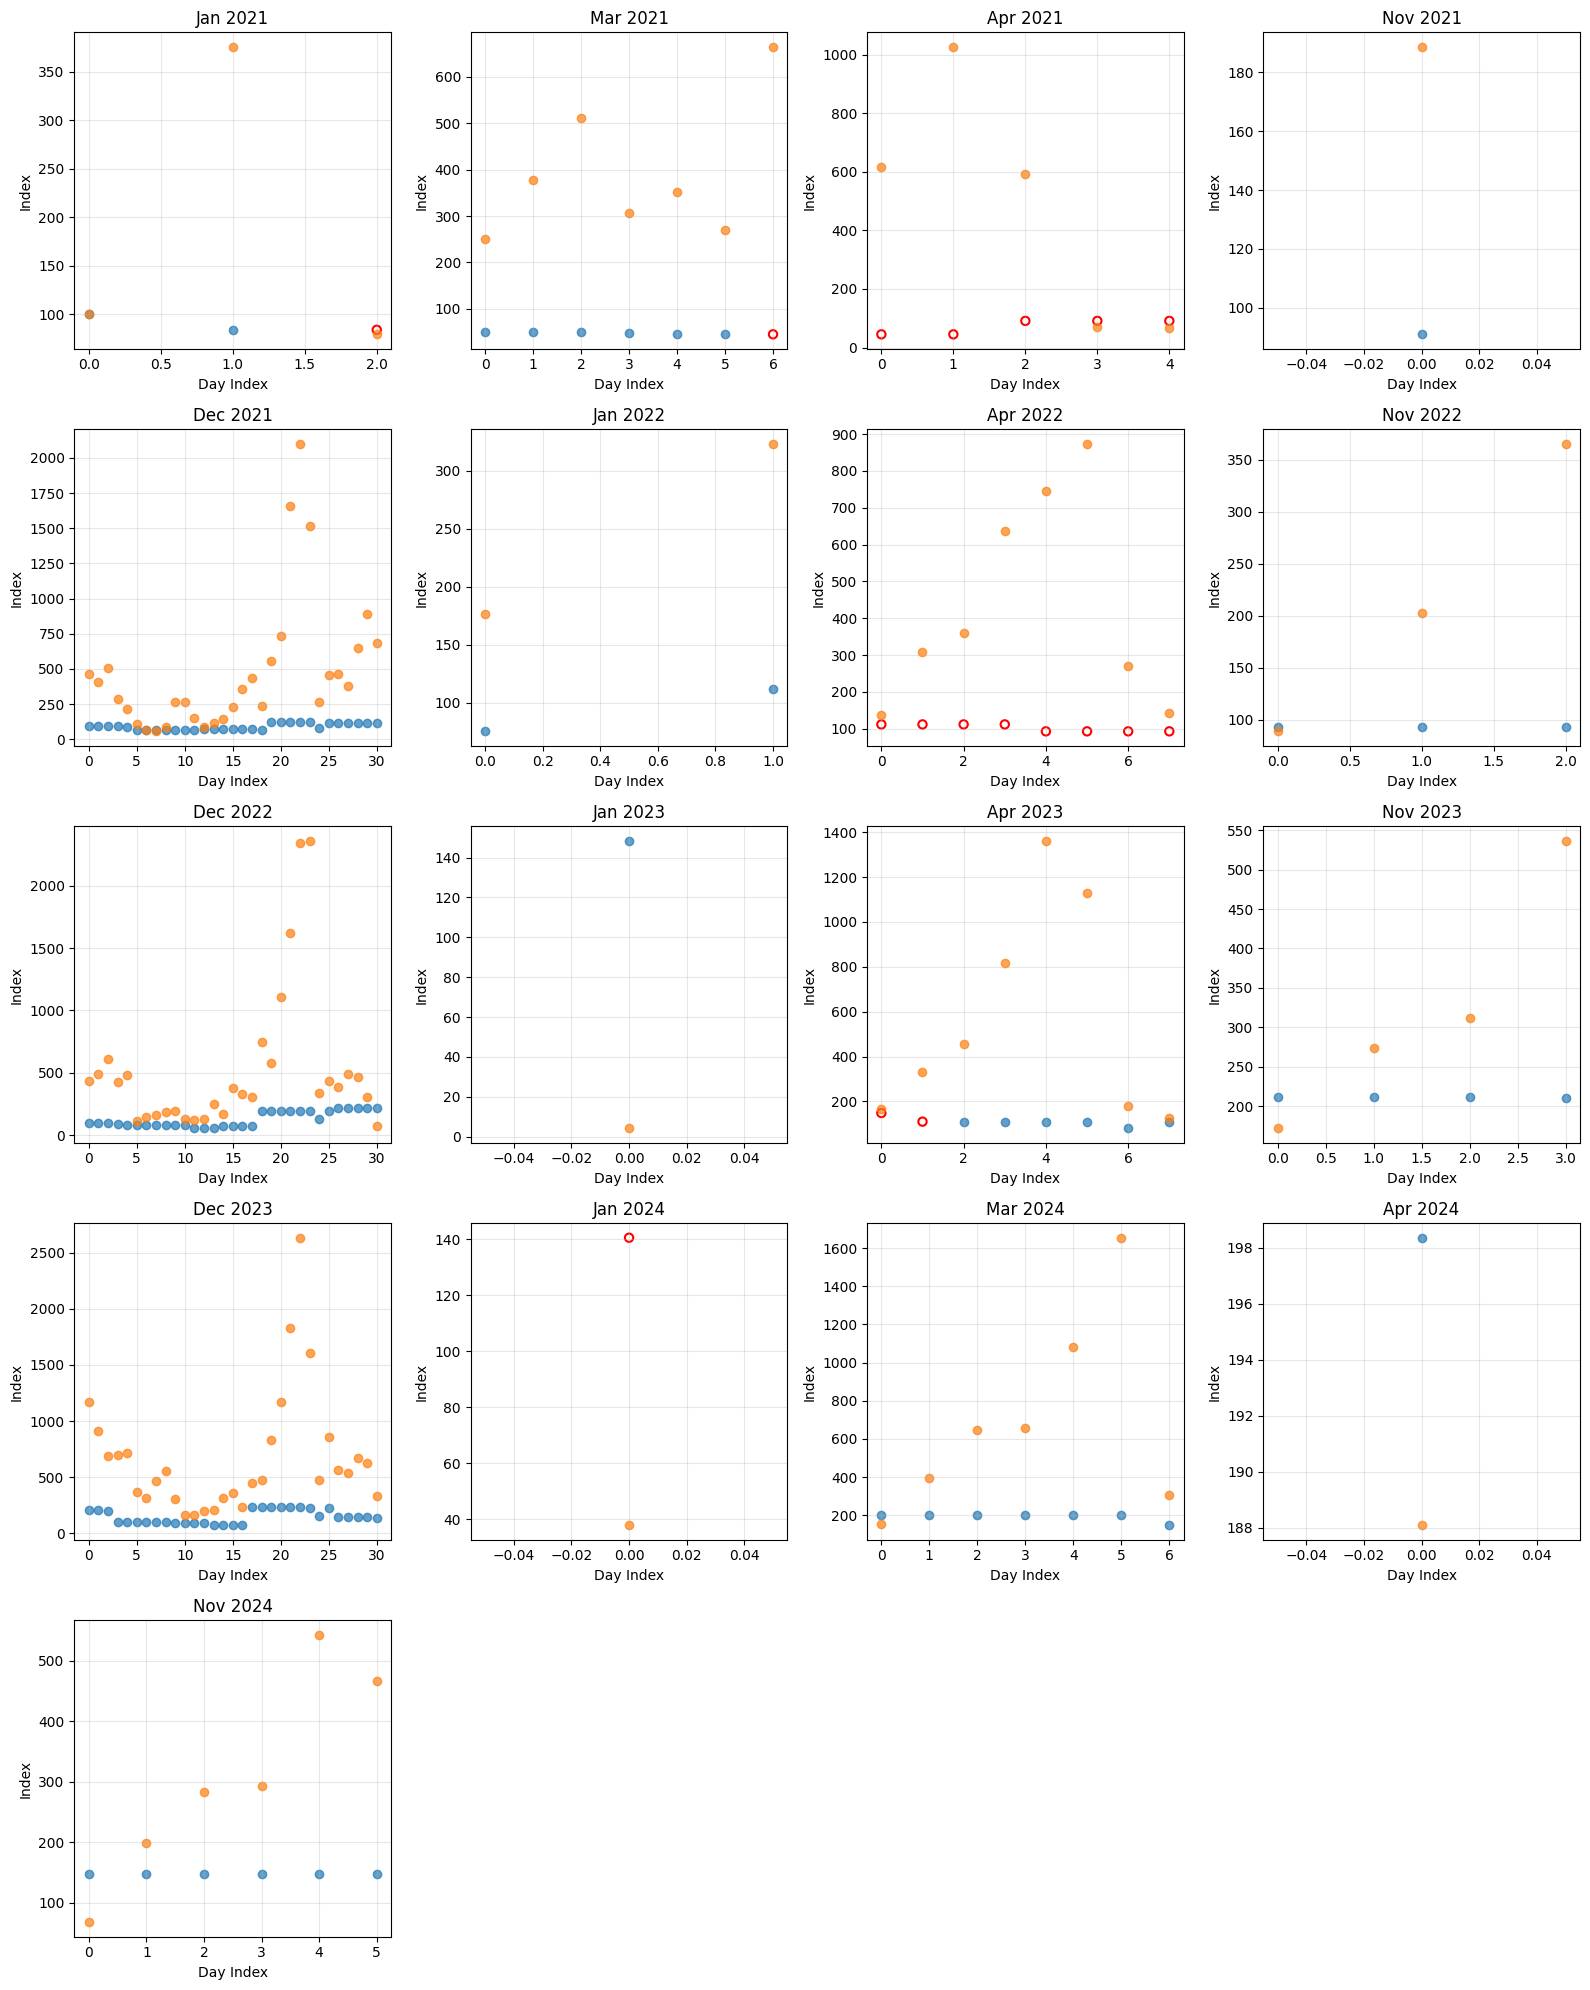

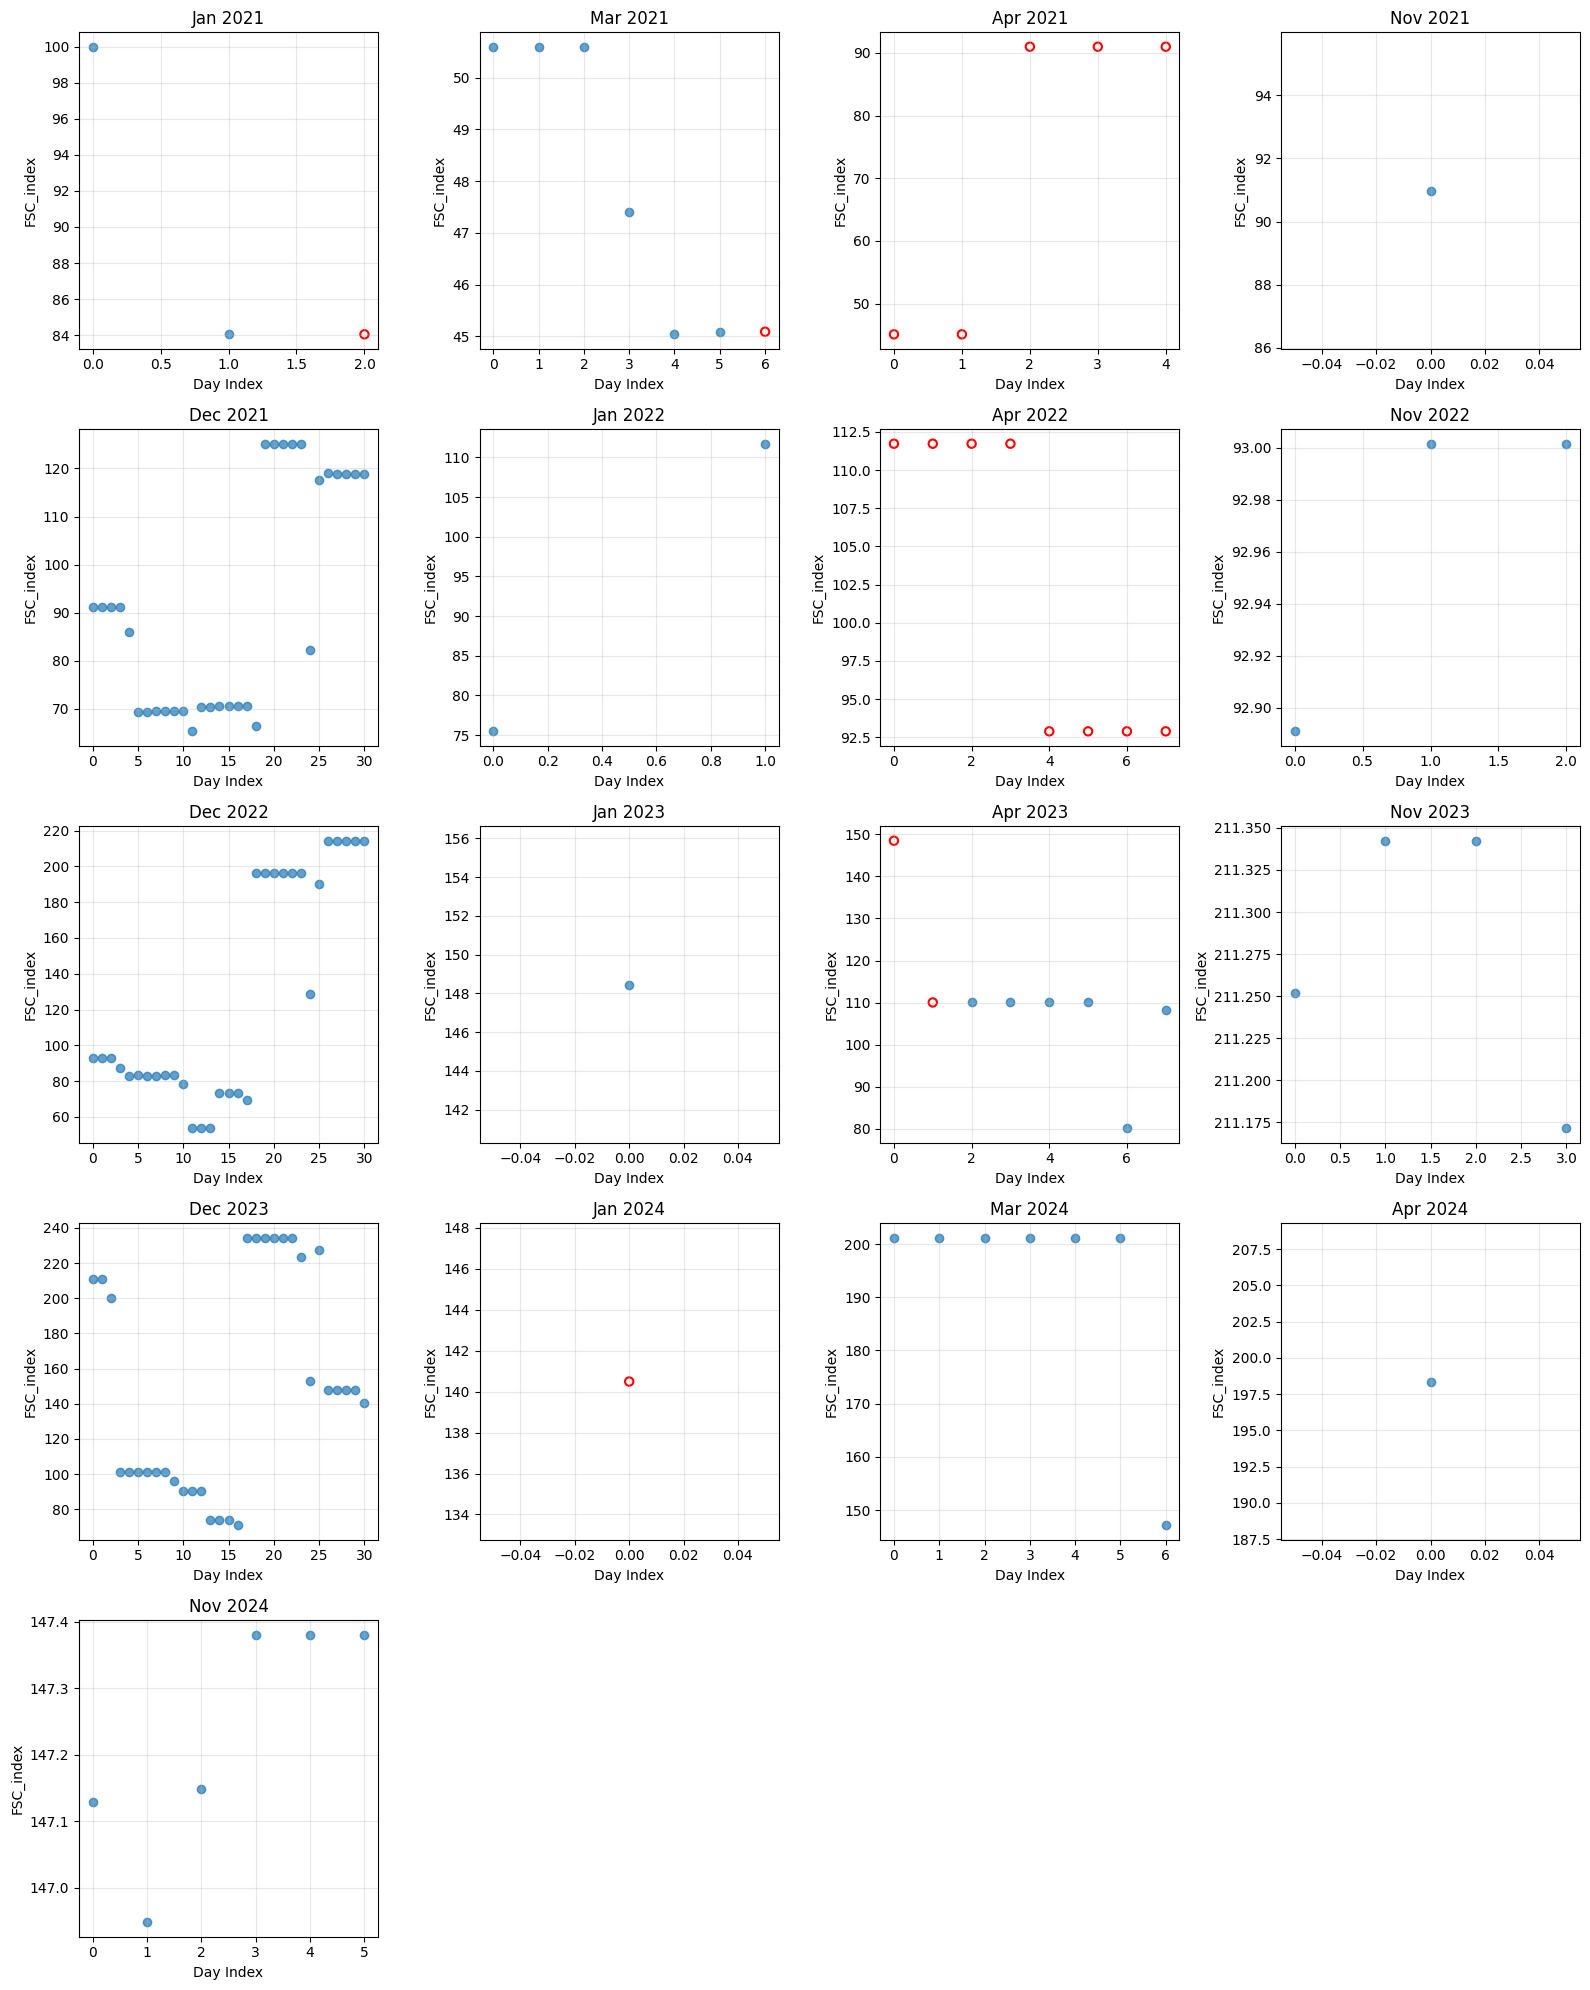

In [17]:
article_id = "ef23f965fa9b01b1e35064be2c6c7d9313e7ed64badb9bfc29ba1ffd2e2cc3f7"
df_article = df_master_train[df_master_train["articleId"] == article_id].copy()

df_article = df_article.sort_values("date").reset_index(drop=True)
df_article["FSC_was_null"] = df_article["FSC_index"].isnull()
df_article["FSC_index"] = df_article["FSC_index"].interpolate(method="nearest")

# --- Plot 1: FSC vs Sales (month grid) ---
df1 = df_article.dropna(subset=["sales_volume_index"]).copy()
df1["year_month"] = df1["date"].dt.to_period("M")
months1 = sorted(df1["year_month"].unique())

n_cols = 4
n_rows = (len(months1) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, m in enumerate(months1):
    ax = axes[i]
    d = df1[df1["year_month"] == m].sort_values("date").reset_index(drop=True)
    d["day_index"] = range(len(d))

    ax.scatter(d.loc[~d["FSC_was_null"], "day_index"],
               d.loc[~d["FSC_was_null"], "FSC_index"], alpha=0.7)
    ax.scatter(d.loc[d["FSC_was_null"], "day_index"],
               d.loc[d["FSC_was_null"], "FSC_index"],
               facecolors="none", edgecolors="red", linewidths=1.5)

    ax.scatter(d["day_index"], d["sales_volume_index"], alpha=0.7)

    ax.set_title(m.strftime("%b %Y"))
    ax.set_xlabel("Day Index")
    ax.set_ylabel("Index")
    ax.grid(True, alpha=0.3)

for j in range(len(months1), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# --- Plot 2: FSC only (month grid) ---
df2 = df_article.copy()
df2["year_month"] = df2["date"].dt.to_period("M")
months2 = sorted(df2["year_month"].unique())

n_rows2 = (len(months2) + n_cols - 1) // n_cols
fig2, axes2 = plt.subplots(n_rows2, n_cols, figsize=(16, 4 * n_rows2))
axes2 = axes2.flatten()

for i, m in enumerate(months2):
    ax = axes2[i]
    d = df2[df2["year_month"] == m].sort_values("date").reset_index(drop=True)
    d["day_index"] = range(len(d))

    ax.scatter(d.loc[~d["FSC_was_null"], "day_index"],
               d.loc[~d["FSC_was_null"], "FSC_index"], alpha=0.7)
    ax.scatter(d.loc[d["FSC_was_null"], "day_index"],
               d.loc[d["FSC_was_null"], "FSC_index"],
               facecolors="none", edgecolors="red", linewidths=1.5)

    ax.set_title(m.strftime("%b %Y"))
    ax.set_xlabel("Day Index")
    ax.set_ylabel("FSC_index")
    ax.grid(True, alpha=0.3)

for j in range(len(months2), len(axes2)):
    axes2[j].set_visible(False)

plt.tight_layout()
plt.show()


In [18]:
df_article = df_master_train[df_master_train["articleId"] == article_id].copy()

missing_per_month = (
    df_article
        .assign(year_month=df_article["date"].dt.to_period("M"))
        .groupby("year_month")["FSC_index"]
        .apply(lambda x: x.isnull().sum())
)

print(missing_per_month)


year_month
2021-01    1
2021-03    1
2021-04    5
2021-11    0
2021-12    0
2022-01    0
2022-04    8
2022-11    0
2022-12    0
2023-01    0
2023-04    2
2023-11    0
2023-12    0
2024-01    1
2024-03    0
2024-04    0
2024-11    0
Freq: M, Name: FSC_index, dtype: int64


In [19]:
# Find rows where discountPct is null but promo_id is not null
# Keep only one row per promo_id with necessary columns for the search
promo_missing_discount = df_master_train[
    (df_master_train['discountPct'].isnull()) & 
    (df_master_train['promo_id'].notna())
][['articleId', 'promo_id', 'date']].drop_duplicates(subset=['promo_id'], keep='first').sort_values('articleId')

In [20]:
# Find past discount percentages for rows with missing discounts
past_discount_results = []

for idx, row in promo_missing_discount.iterrows():
    article_id = row['articleId']
    current_date = row['date']
    
    # Find past occurrences with the same articleId and non-null discountPct
    past_discounts = df_master_train[
        (df_master_train['articleId'] == article_id) & 
        (df_master_train['discountPct'].notna()) &
        (df_master_train['date'] < current_date)  # Only past dates
    ]['discountPct']
    
    past_discounts_same_month_prev_years = df_master_train[
        (df_master_train["articleId"] == article_id) &
        (df_master_train["discountPct"].notna()) &
        (df_master_train["date"] < current_date) &                 # only past dates
        (df_master_train["date"].dt.month == current_date.month) & # same month number
        (df_master_train["date"].dt.year < current_date.year)      # previous years only
    ]["discountPct"]
    
    # Compute modes
    mode_discount = past_discounts.mode().iloc[0] if len(past_discounts) > 0 and not past_discounts.mode().empty else None
    mode_discount_same_month = (
        past_discounts_same_month_prev_years.mode().iloc[0]
        if len(past_discounts_same_month_prev_years) > 0 and not past_discounts_same_month_prev_years.mode().empty
        else None
    )
    
    # Store results
    result = {
        'original_index': idx,
        'date': current_date,
        'articleId': article_id,
        'promo_id': row['promo_id'],
        'past_discounts_count': len(past_discounts),
        'mean_discount': past_discounts.mean() if len(past_discounts) > 0 else None,
        'median_discount': past_discounts.median() if len(past_discounts) > 0 else None,
        'mode_discount': mode_discount,
        'min_discount': past_discounts.min() if len(past_discounts) > 0 else None,
        'max_discount': past_discounts.max() if len(past_discounts) > 0 else None,
        'std_discount': past_discounts.std() if len(past_discounts) > 0 else None,
        'past_discounts_count_same_month': len(past_discounts_same_month_prev_years),
        'mean_discount_same_month': past_discounts_same_month_prev_years.mean() if len(past_discounts_same_month_prev_years) > 0 else None,
        'median_discount_same_month': past_discounts_same_month_prev_years.median() if len(past_discounts_same_month_prev_years) > 0 else None,
        'mode_discount_same_month': mode_discount_same_month,
        'min_discount_same_month': past_discounts_same_month_prev_years.min() if len(past_discounts_same_month_prev_years) > 0 else None,
        'max_discount_same_month': past_discounts_same_month_prev_years.max() if len(past_discounts_same_month_prev_years) > 0 else None,
        'std_discount_same_month': past_discounts_same_month_prev_years.std() if len(past_discounts_same_month_prev_years) > 0 else None,
    }
    
    past_discount_results.append(result)

# Convert to DataFrame
past_discounts_df = pd.DataFrame(past_discount_results)
past_discounts_df = past_discounts_df.sort_values(by=["articleId", "date"], ascending=[True, True])

In [21]:
# Fill null discountPct in df_master_train using past_discounts_df

# Work on a copy of the source table
p = past_discounts_df.copy()

# Ensure date is datetime for nearest-date selection
p["date"] = pd.to_datetime(p["date"], errors="coerce")

# Primary fill: prefer same-month mode, else overall mode
p["fill"] = p["mode_discount_same_month"].fillna(p["mode_discount"])

# Fallback: get mode_discount from another promo for the same article (closest date)
def _alt_mode(r):
    g = p[
        (p.articleId == r.articleId) &
        (p.promo_id != r.promo_id) &
        (p.mode_discount.notna())
    ]
    if g.empty:
        return np.nan
    return g.loc[(g["date"] - r["date"]).abs().idxmin(), "mode_discount"]

# Apply fallback only where still missing
m = p["fill"].isna()
p.loc[m, "fill"] = p.loc[m].apply(_alt_mode, axis=1)

# Build a promo-level lookup for the filled values
promo_fill = (
    p.dropna(subset=["fill"])
     .drop_duplicates("promo_id")
     .set_index("promo_id")["fill"]
)

# Final update on df_master_train: fill only missing discountPct
m = df_master_train["discountPct"].isna() & df_master_train["promo_id"].notna()
df_master_train.loc[m, "discountPct"] = df_master_train.loc[m, "promo_id"].map(promo_fill)

In [22]:
# Missing data check - now that we have filled the null discountPct
missing_data = df_master_train.isnull().sum()
missing_pct = (missing_data / len(df_master_train)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print(missing_df)

# Save the null-handled training data back to the same file
df_master_train.to_csv(master_train_path, index=False)
print(f"Null-handled training data saved back to: {master_train_path}")


                  Missing Count  Missing Percentage
holidayEventName         329478           95.820549
promo_id                 297837           86.618545
discountPct              297837           86.618545
FSC_index                    18            0.005235
Null-handled training data saved back to: /Users/gavinshao/Desktop/Seminar BAQM/BAQM_Seminar/data/merged_data/master_train.csv


In [23]:
# Save the null-handled training data back to the same file
df_master_train.to_csv(master_train_path, index=False)